# Animated graphs

## About ANIM notebooks

ANIM notebooks are auxiliary production tools used to generate
visual assets and animations for videos and presentations.

They:
- rely on precomputed data products,
- prioritize visual clarity over strict statistical completeness,
- may include smoothing, interpolation, or stylistic choices.

They are not intended to reproduce scientific figures exactly.

## Cell 0 — Bootstrap (imports, paths, i18n) + animation export settings

### Purpose of this cell

This cell initializes the notebook runtime and defines *all global controls* that affect animation rendering and export.

It merges two roles into a single, predictable “bootstrap” entry point:

1) **Infrastructure**
- imports and reusable helpers,
- project paths (topic root, processed data, animation output directory),
- theme application,
- i18n setup (labels/titles for the notebook language).

2) **Animation export configuration**
- a small set of top-level constants controlling:
  - output format (`gif` / `mp4`),
  - fps / dpi,
  - codec / bitrate for MP4,
  - writer / loop settings for GIF.

Keeping these settings in one place makes animation notebooks easy to rerun with different:
- languages (`en` / `ru`),
- themes (`light` / `dark`),
- export targets (GIF previews vs MP4 finals),

without touching the downstream plotting / rendering cells.


### What gets defined here (global knobs)

**Animation export**
- `ANIM_FORMAT` — `"gif"` or `"mp4"` (single switch)
- `FPS`, `DPI` — common quality controls
- MP4 options: `MP4_CODEC`, `MP4_BITRATE`
- GIF options: `GIF_WRITER`, `GIF_LOOP`

**Theme**
- `THEME` — `"light"` or `"dark"` (single switch, used to apply the theme)

At the end of the cell we print the chosen values as a quick sanity check, so it’s always obvious what configuration was used to generate the outputs.

This bootstrap pattern is intentionally consistent across ANIM notebooks (ANIM_001, ANIM_002, …), enabling a uniform production workflow.

In [12]:
# =========================================================
# Cell 0 — Universal bootstrap (globals, paths, theme, i18n)
# Works for: ACAP_* and ANIM_*
# =========================================================

from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th
from astroquery.vizier import Vizier
from tqdm import tqdm
import lulab.i18n.plot_text as pt
import lulab.anim.defaults as animd
from lulab.anim.defaults import save_animation

# -----------------------------
# External services (Vizier)
# -----------------------------
# No row limit by default
Vizier.ROW_LIMIT = -1

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ANIM_001"   # e.g. "ACAP_001", "ANIM_001"
LANG: str = "ru"             # "en" / "ru"
THEME: str = "light"          # "light" / "dark"

# -----------------------------
# Animation export settings (safe to keep for ACAP too)
# -----------------------------
ANIM_FORMAT = "gif"       # "gif" / "mp4"
FPS = 24
DPI = 200

MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"
GIF_LOOP = 0

# sync notebook settings -> module defaults used by save_animation()
animd.ANIM_FORMAT  = ANIM_FORMAT
animd.FPS          = FPS
animd.DPI          = DPI
animd.MP4_CODEC    = MP4_CODEC
animd.MP4_BITRATE  = MP4_BITRATE
animd.GIF_LOOP     = GIF_LOOP

# --- physical limits (keep consistent) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Common paths
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)

DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)

ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# --- legacy aliases (do NOT remove, used in older cells) ---
RAW  = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR

# -----------------------------
# Theme
# -----------------------------
# Use a single consistent entry point everywhere
th.apply_theme(THEME)

# -----------------------------
# Save helpers
# -----------------------------
def save_fig0(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> build artifact ID:
        ANIM_001_Figure_3
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

def anim_outpath(anim_id: str, ext: str | None = None) -> Path:
    """
    Standard output path for animations.
    Example:
        out = anim_outpath("Orbit_1")  -> ANIM_DIR/ANIM_001_Orbit_1.mp4
        out = anim_outpath("Orbit_1", ext="gif")
    """
    if ext is None:
        ext = ANIM_FORMAT
    return ANIM_DIR / f"{NOTEBOOK}_{anim_id}.{ext}"

# -----------------------------
# i18n bootstrap (force reload to avoid stale imports)
# -----------------------------
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)

# convenience aliases (stable)
L = pt.L
T = pt.T

import re

def _slug(s: str) -> str:
    s = str(s).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def anim_base(name: str, *, notebook: str = NOTEBOOK) -> Path:
    """
    Returns ANIM_DIR / "<NOTEBOOK>_<slug(name)>" WITHOUT suffix.
    Use ONLY this with save_animation().
    """
    return (ANIM_DIR / f"{notebook}_{_slug(name)}")

# -----------------------------
# Quick sanity printout
# -----------------------------
print("\n--- BOOTSTRAP ---")
print("TOPIC      :", TOPIC)
print("NOTEBOOK   :", NOTEBOOK)
print("LANG       :", LANG)
print("THEME      :", THEME)
print("TOPIC_ROOT :", TOPIC_ROOT)
print("FIG_DIR    :", FIG_DIR)
print("DATA_RAW   :", DATA_RAW_DIR)
print("DATA_PROC  :", DATA_PROCESSED_DIR)
print("ANIM_DIR   :", ANIM_DIR)
print("ANIM_FORMAT:", animd.ANIM_FORMAT)
print("FPS / DPI  :", FPS, "/", DPI)


--- BOOTSTRAP ---
TOPIC      : TOP_0001_exoplanet_birth_radius
NOTEBOOK   : ANIM_001
LANG       : ru
THEME      : light
TOPIC_ROOT : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
FIG_DIR    : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/ru
DATA_RAW   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw
DATA_PROC  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
ANIM_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
ANIM_FORMAT: gif
FPS / DPI  : 24 / 200


---

## 1. Animation helpers

## Animation helper functions

This section defines a set of **generic animation helper functions** that are reused throughout the animation notebooks.

These functions:
- operate only on already-prepared numerical data,
- do **not** load data from disk,
- do **not** perform language or theme selection,
- and do **not** save files to disk.

Each helper returns a `matplotlib.animation.FuncAnimation` object.  
Saving the animation (as MP4 or GIF), choosing language-dependent labels, and selecting the visual theme are handled **outside** these helpers, in the animation-specific cells that follow.

This separation ensures that:
- the animation logic remains clean and reusable,
- internationalization (i18n) is applied consistently at a higher level,
- and the same helpers can be used for figures, videos, and short-form content.


### Helper 1 — Histogram reveal animation (linear fill)

This helper creates a **smooth reveal animation for histograms**, where the height of each bin increases linearly from zero to its final value.

#### Purpose

The animation is designed to:
- visualize the shape of distributions,
- compare multiple samples on the same axis,
- and provide a clean, publication-style dynamic effect without introducing artificial motion.

Typical use cases include:
- SWEET-Cat vs HARPS comparisons,
- inner vs outer disk distributions,
- toy vs reference model histograms.

#### How it works

- The final histogram heights are computed **once** using `numpy.histogram`.
- Axis limits are fixed before the animation starts, preventing rescaling artifacts.
- During the animation, bin heights are scaled by a factor that grows linearly from 0 to 1.
- Multiple datasets can be animated simultaneously using semi-transparent bars.

#### Inputs

- numerical data series (already filtered and prepared),
- labels and axis titles (passed explicitly for i18n),
- optional visual parameters (bin count, range, duration).

#### Output

- A `FuncAnimation` object representing the animated histogram.
- The animation is **not saved** at this stage.



### 1.1. Histogram - linear

In [13]:
def animate_hist_reveal(
    series_list,
    labels,
    *,
    colors=None,
    title="",
    xlabel="",
    ylabel="",          # i18n comes from caller
    bins=30,
    rmin=None,
    rmax=None,
    frames=60,
    interval=33,
    legend_loc="upper right",
    grid_alpha=0.25,
):
    """
    Reveal precomputed histogram heights linearly from 0 -> full value.

    Notes:
      - i18n-safe: no globals (LABELS/L/T). All text is passed in.
      - If rmin/rmax are not provided, they are derived from concatenated data.
    """
    if colors is None:
        colors = [None] * len(series_list)

    fig, ax = plt.subplots(figsize=(10, 5))  # ~16:9
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=grid_alpha)

    # fixed range
    data_all = np.concatenate([s.to_numpy() for s in series_list if len(s) > 0])
    if rmin is None:
        rmin = float(np.nanmin(data_all))
    if rmax is None:
        rmax = float(np.nanmax(data_all))

    # precompute hist heights
    hist_data = []
    edges = None
    for s in series_list:
        h, e = np.histogram(s, bins=bins, range=(rmin, rmax), density=True)
        hist_data.append(h)
        edges = e

    # y-range (stable headroom)
    ymax = max(h.max() for h in hist_data if len(h) > 0)
    ax.set_ylim(0, ymax * 1.15)

    # bars (one container per dataset)
    bar_containers = []
    width = edges[1] - edges[0]
    for i, h in enumerate(hist_data):
        bc = ax.bar(
            edges[:-1],
            np.zeros_like(h),
            width=width,
            align="edge",
            alpha=0.45,
            edgecolor="k",
            label=labels[i],
            color=colors[i],
        )
        bar_containers.append(bc)

    ax.set_xlim(rmin, rmax)
    ax.legend(loc=legend_loc)

    def update(frame):
        t = (frame + 1) / frames  # 0..1
        for bc, h in zip(bar_containers, hist_data):
            for rect, hh in zip(bc.patches, h):
                rect.set_height(hh * t)
        return [p for bc in bar_containers for p in bc.patches]

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim

### Helper 2 — Histogram reveal animation (staggered / equalizer-style)

This helper is a stylistic variant of the linear histogram reveal.

#### Purpose

Instead of all bins growing synchronously, bins are revealed with a phase shift or randomized timing, producing an **equalizer-like visual effect**.

This variant is particularly useful for:
- short-form videos (Reels, Shorts, TikTok),
- background scientific animations,
- or when a more dynamic aesthetic is desired.

#### Design philosophy

- The underlying data are identical to the linear version.
- Only the temporal behavior of bin growth differs.
- The function remains fully deterministic once the random seed (if any) is fixed.

As with all helpers, no assumptions are made about:
- data origin,
- language,
- or output format.



### 1.2. Histogram - equalizer

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def _smooth_1d(x, kernel):
    """Simple 1D convolution smoothing with edge padding."""
    x = np.asarray(x, float)
    k = np.asarray(kernel, float)
    k = k / k.sum()
    pad = len(k) // 2
    xp = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(xp, k, mode="valid")

def animate_hist_equalizer(
    series_list,
    labels,
    *,
    colors=None,
    title="",
    xlabel="",
    ylabel="",              # i18n comes from caller
    bins=30,
    rmin=None,
    rmax=None,
    frames=60,
    interval=33,
    jitter_strength=0.55,
    settle_last=6,
    seed=42,
    smooth_kernel=(1, 2, 3, 2, 1),
    smooth_passes=2,
    noise_clip=(0.0, 2.5),
    legend_loc="upper right",
    grid_alpha=0.25,
):
    """
    Histogram 'equalizer' animation with smoothed jitter:
      - Bars reveal from 0 to true heights (density=True hist)
      - Multiplicative jitter is smoothed across bins (neighbor-coherent motion)
      - Jitter amplitude decays to 0; last settle_last frames are exact histogram

    i18n-safe: no globals (LABELS/L/T). All text is passed in.
    """
    rng = np.random.default_rng(seed)
    if colors is None:
        colors = [None] * len(series_list)

    fig, ax = plt.subplots(figsize=(10, 5))  # ~16:9
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=grid_alpha)

    # fixed range
    data_all = np.concatenate([s.to_numpy() for s in series_list if len(s) > 0])
    if rmin is None:
        rmin = float(np.nanmin(data_all))
    if rmax is None:
        rmax = float(np.nanmax(data_all))

    # precompute hist heights (density)
    hist_data = []
    edges = None
    for s in series_list:
        h, e = np.histogram(s, bins=bins, range=(rmin, rmax), density=True)
        hist_data.append(h.astype(float))
        edges = e

    # y-range (stable headroom)
    ymax = max(h.max() for h in hist_data if len(h) > 0)
    ax.set_ylim(0, ymax * 1.15)

    # bars (one container per dataset)
    bar_containers = []
    width = edges[1] - edges[0]
    for i, h in enumerate(hist_data):
        bc = ax.bar(
            edges[:-1],
            np.zeros_like(h),
            width=width,
            align="edge",
            alpha=0.45,
            edgecolor="k",
            label=labels[i],
            color=colors[i],
        )
        bar_containers.append(bc)

    ax.set_xlim(rmin, rmax)
    ax.legend(loc=legend_loc)

    # helper: smooth step (nicer than linear)
    def smooth01(t):
        t = np.clip(t, 0, 1)
        return t * t * (3 - 2 * t)

    def make_smoothed_noise(nbins, amp):
        # multiplicative noise around 1.0
        z = rng.normal(0.0, 1.0, nbins)
        for _ in range(max(1, smooth_passes)):
            z = _smooth_1d(z, smooth_kernel)
        factor = 1.0 + amp * z
        return np.clip(factor, noise_clip[0], noise_clip[1])

    def update(frame):
        # progress 0..1
        t = smooth01((frame + 1) / frames)

        # settle: last N frames have zero jitter for perfect final frame
        amp = 0.0 if frame >= frames - settle_last else jitter_strength * (1.0 - t)

        artists = []
        for bc, h_true in zip(bar_containers, hist_data):
            h_base = h_true * t
            h_draw = h_base * make_smoothed_noise(len(h_true), amp) if amp > 0 else h_base

            for rect, hh in zip(bc.patches, h_draw):
                rect.set_height(float(hh))
                artists.append(rect)

        return artists

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim



### Helper 3 — Line animation (left-to-right drawing)

This helper animates a line plot by **progressively revealing it from left to right**.

#### Purpose

The animation emphasizes:
- trends,
- evolutionary behavior,
- monotonic relationships between variables.

Typical applications include:
- planet-host frequency vs age,
- frequency vs birth radius,
- time-dependent Galactic trends.

#### How it works

- The full x/y data arrays are prepared in advance.
- At each animation frame, only the first *N* points are drawn.
- The axes remain fixed to preserve visual stability.

This approach creates a clear narrative flow and is especially well suited for explanatory videos.



### 1.3. Lines

In [15]:
def animate_lines_draw(x, y_list, labels, title="", xlabel="", ylabel="", colors=None,
                       frames=80, interval=33, ylim=None):
    if colors is None:
        colors = [None]*len(y_list)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)
    if ylim is not None:
        ax.set_ylim(*ylim)

    lines = []
    for y, lab, col in zip(y_list, labels, colors):
        (ln,) = ax.plot([], [], marker="o", linewidth=2, label=lab, color=col)
        lines.append(ln)
    ax.set_xlim(np.min(x), np.max(x))
    ax.legend()

    def update(frame):
        k = int((frame + 1) / frames * len(x))
        k = max(1, min(k, len(x)))
        for ln, y in zip(lines, y_list):
            ln.set_data(x[:k], y[:k])
        return lines

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim


### Helper 4 — Scatter reveal animation (randomized appearance)

This helper animates scatter plots by **revealing points in random order**.

#### Purpose

Randomized reveal is ideal for:
- dense point clouds,
- spatial distributions,
- population diagrams where no natural ordering exists.

It avoids visually misleading left-to-right or bottom-to-top ordering and creates an organic appearance of the data.

#### How it works

- The full dataset is randomly permuted once.
- Points are progressively added to the scatter plot at each frame.
- Axis limits are fixed from the beginning.



### 1.4. Scatter

In [16]:
def animate_scatter_reveal(x, y, title="", xlabel="", ylabel="", color=None,
                           frames=80, interval=33, s=22):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2)

    n = len(x)
    order = np.argsort(x)  # приятнее “слева направо”
    x = np.asarray(x)[order]
    y = np.asarray(y)[order]

    sc = ax.scatter([], [], s=s, color=color, edgecolors="k", linewidths=0.3)

    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))

    def update(frame):
        k = int((frame + 1) / frames * n)
        k = max(1, min(k, n))
        sc.set_offsets(np.c_[x[:k], y[:k]])
        return (sc,)

    anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)
    return anim


### Notes on internationalization (i18n)

All animation helpers are **language-agnostic** by design.

- Titles, axis labels, and legend text are passed as function arguments.
- Language selection is handled upstream via the i18n system.
- This ensures that the same animation logic can be reused for:
  - English and Russian versions,
  - light and dark themes,
  - different output formats.

This design mirrors the structure used in the ACAP notebooks and keeps animation code maintainable and transparent.

---

## 2. Examples

### 2.1. Distribution of host stars by effective temperature for both data samples

### Animation: HR Diagram Reveal (Teff–log g)

This cell generates an animated **Hertzsprung–Russell–like diagram** (effective temperature vs surface gravity) for the combined **SWEET-Cat** and **HARPS-GTO** samples, illustrating how different stellar populations populate the HR diagram.

#### Data sources
Only **processed CSV files** produced earlier in the pipeline are used:
- `sweetcat_ages_grid.csv` — SWEET-Cat stars,
- `harps_ages_grid.csv` — HARPS-GTO stars with a `class` column (`single` / host).

No external services (Vizier, NEA) are queried at this stage, ensuring full reproducibility and fast execution.

#### What the animation shows
Three stellar populations are displayed simultaneously:
- **SWEET-Cat stars**,
- **HARPS single stars**,
- **HARPS planet hosts**.

Points are progressively revealed on the HR diagram, allowing the viewer to visually track how the diagram “fills up” over time.

#### Reveal modes
The animation supports two reveal strategies:
- **Left-to-right (LR)**:  
  Points are revealed from left to right *on screen*.  
  Because the HR diagram uses inverted axes, this corresponds to revealing stars in order of **decreasing effective temperature**.  
  Importantly, the ordering is applied **independently within each stellar class**, which avoids artificial gaps in the distribution.
- **Random**:  
  Points appear in random order (again independently within each class), useful as a control visualization.

#### Timing and pacing
- The reveal phase lasts a fixed number of seconds (e.g. ~3 s).
- A final **hold (freeze-frame)** phase keeps the fully populated diagram on screen for several additional seconds.
- The number of points added per frame is controlled separately for each stellar class, maintaining visually balanced growth across populations.

#### Styling and conventions
- Standard HR-diagram conventions are used:
  - inverted temperature axis,
  - inverted surface-gravity axis.
- Axis labels, titles, and legend entries are fully **i18n-aware** and are resolved via the shared YAML translation files.
- Colors are chosen to remain readable in both light and dark themes.

Overall, this animation provides an intuitive, didactic visualization of how different stellar samples occupy distinct regions of the HR diagram, and serves as an animated counterpart to the static figures used elsewhere in the practicum.

SWEET: 605 | HARPS single: 941 | HARPS host: 170
X_TEFF: $T_{\rm eff}$ (K)
Y_LOGG: $\log\, g\,({\rm dex})$
TITLE : Диаграмма Киля (Teff vs log g): анимированное проявление
LEG   : SWEET-Cat | HARPS: одиночные | HARPS: хосты
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_hrd_reveal_lr.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_hrd_reveal_lr.gif exists: True


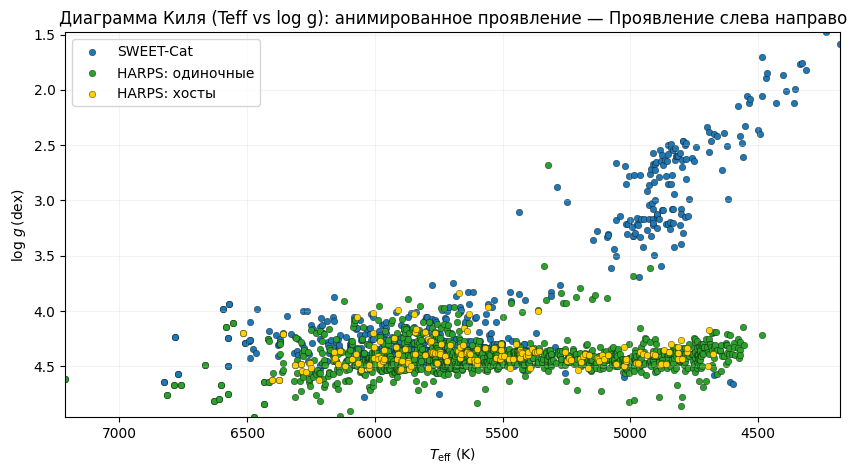

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_hrd_reveal_random.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_hrd_reveal_random.gif exists: True


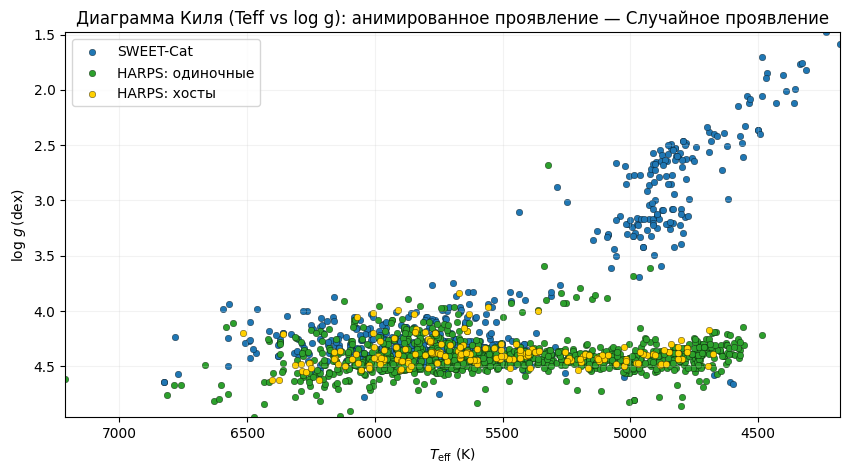

In [17]:
# =========================================================
# [ANIM_001|ANIM_01] HR diagram reveal (Teff–logg)
#   SWEET-Cat vs HARPS-GTO (single/hosts)
#   New architecture: load ONLY processed CSVs, no Vizier/NEA.
#   i18n-safe: L/T return key string if missing.
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 1) Load processed data (no external services)
# -----------------------------
sweet = pd.read_csv(PROC / "sweetcat_ages_grid.csv")
harps = pd.read_csv(PROC / "harps_ages_grid.csv")

sweet = sweet[["Teff", "logg"]].dropna()
harps = harps[["Teff", "logg", "class"]].dropna()

sweet = sweet[(sweet["Teff"] > 0) & (sweet["logg"] > 0)].copy()
harps = harps[(harps["Teff"] > 0) & (harps["logg"] > 0)].copy()

harps_single = harps[harps["class"] == "single"].copy()
harps_host   = harps[harps["class"] != "single"].copy()

print("SWEET:", len(sweet), "| HARPS single:", len(harps_single), "| HARPS host:", len(harps_host))

# -----------------------------
# 2) i18n text (labels/titles)
# -----------------------------
X_TEFF = L("teff")
Y_LOGG = L("logg")

TITLE_BASE = T("figure_1")
TITLE_LR   = f"{TITLE_BASE} — {T('figure_1_lr')}"
TITLE_RAND = f"{TITLE_BASE} — {T('figure_1_random')}"

LEG_SWEET = L("legend_sweet")
LEG_HSING = L("legend_harps_single")
LEG_HHOST = L("legend_harps_host")

print("X_TEFF:", X_TEFF)
print("Y_LOGG:", Y_LOGG)
print("TITLE :", TITLE_BASE)
print("LEG   :", LEG_SWEET, "|", LEG_HSING, "|", LEG_HHOST)


# -----------------------------
# 3) Animation function (scatter reveal)
# -----------------------------
def anim_logg_teff_combined(
    sweet_df: pd.DataFrame,
    harps_single_df: pd.DataFrame,
    harps_host_df: pd.DataFrame,
    *,
    title: str,
    xlabel: str,
    ylabel: str,
    mode: str = "lr",  # "lr" or "random"
    sweet_per_frame: int = 12,
    single_per_frame: int = 18,
    host_per_frame: int = 6,
    seed: int = 1,
    reveal_seconds: float = 3.0,
    hold_seconds: float = 3.0,):

    """
    HRD scatter reveal without artificial gaps:
    - LR mode: reveal left->right on screen by sorting EACH class by Teff (desc, since x-axis is inverted).
    - Random mode: random order WITHIN each class (still keeps class proportions stable).
    - Adds a hold at the end (freeze last frame).
    """

    # --------- sanitize / extract arrays ----------
    sweet = sweet_df[["Teff", "logg"]].dropna().copy()
    sng   = harps_single_df[["Teff", "logg"]].dropna().copy()
    host  = harps_host_df[["Teff", "logg"]].dropna().copy()

    # convert to numpy
    sweet_x, sweet_y = sweet["Teff"].to_numpy(float), sweet["logg"].to_numpy(float)
    sng_x,   sng_y   = sng["Teff"].to_numpy(float),   sng["logg"].to_numpy(float)
    host_x,  host_y  = host["Teff"].to_numpy(float),  host["logg"].to_numpy(float)

    rng = np.random.default_rng(seed)

    def _order(x):
        if mode == "lr":
            # screen-left is high Teff because x is inverted => sort by decreasing Teff
            return np.argsort(-x)
        elif mode == "random":
            return rng.permutation(len(x))
        else:
            raise ValueError("mode must be 'lr' or 'random'")

    osw = _order(sweet_x)
    osn = _order(sng_x)
    osh = _order(host_x)

    # ordered arrays per class
    sweet_x, sweet_y = sweet_x[osw], sweet_y[osw]
    sng_x,   sng_y   = sng_x[osn],   sng_y[osn]
    host_x,  host_y  = host_x[osh],  host_y[osh]

    # --------- figure setup ----------
    c_sweet  = "tab:blue"
    c_single = "tab:green"
    c_host   = "#FFD000"

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)

    ax.invert_xaxis()
    ax.invert_yaxis()

    # fixed limits over ALL points (so axes don’t jump)
    all_x = np.concatenate([sweet_x, sng_x, host_x]) if len(host_x) else np.concatenate([sweet_x, sng_x])
    all_y = np.concatenate([sweet_y, sng_y, host_y]) if len(host_y) else np.concatenate([sweet_y, sng_y])

    xmin, xmax = float(np.nanmin(all_x)), float(np.nanmax(all_x))
    ymin, ymax = float(np.nanmin(all_y)), float(np.nanmax(all_y))

    ax.set_xlim(xmax, xmin)  # inverted
    ax.set_ylim(ymax, ymin)  # inverted

    sc_sweet  = ax.scatter([], [], s=22, color=c_sweet,  edgecolors="k", linewidths=0.25, label=LEG_SWEET)
    sc_single = ax.scatter([], [], s=22, color=c_single, edgecolors="k", linewidths=0.25, label=LEG_HSING)
    sc_host   = ax.scatter([], [], s=22, color=c_host,   edgecolors="k", linewidths=0.25, label=LEG_HHOST)
    ax.legend(loc="upper left", frameon=True)

    # --------- frame budgeting ----------
    fps = FPS
    reveal_frames = max(1, int(round(reveal_seconds * fps)))
    hold_frames   = max(0, int(round(hold_seconds * fps)))

    # how many points total we will reveal over reveal_frames
    sw_total = min(len(sweet_x), reveal_frames * sweet_per_frame)
    sn_total = min(len(sng_x),   reveal_frames * single_per_frame)
    ho_total = min(len(host_x),  reveal_frames * host_per_frame)

    # growing buffers
    xs, ys = [], []
    xg, yg = [], []
    xh, yh = [], []

    def _slice_for_frame(f, per_frame, total):
        start = f * per_frame
        end = min((f + 1) * per_frame, total)
        return start, end

    def update(f):
        # hold: keep last state
        if f >= reveal_frames:
            return (sc_sweet, sc_single, sc_host)

        a0, a1 = _slice_for_frame(f, sweet_per_frame, sw_total)
        b0, b1 = _slice_for_frame(f, single_per_frame, sn_total)
        c0, c1 = _slice_for_frame(f, host_per_frame, ho_total)

        if a0 < a1:
            xs.extend(sweet_x[a0:a1].tolist())
            ys.extend(sweet_y[a0:a1].tolist())
        if b0 < b1:
            xg.extend(sng_x[b0:b1].tolist())
            yg.extend(sng_y[b0:b1].tolist())
        if c0 < c1:
            xh.extend(host_x[c0:c1].tolist())
            yh.extend(host_y[c0:c1].tolist())

        sc_sweet.set_offsets(np.c_[xs, ys] if xs else np.empty((0, 2)))
        sc_single.set_offsets(np.c_[xg, yg] if xg else np.empty((0, 2)))
        sc_host.set_offsets(np.c_[xh, yh] if xh else np.empty((0, 2)))
        return (sc_sweet, sc_single, sc_host)

    total_frames = reveal_frames + hold_frames
    interval_ms = int(1000 / fps)

    anim = FuncAnimation(fig, update, frames=total_frames, interval=interval_ms, blit=False)
    return anim, fig

# -----------------------------
# 4) Build + save animations
# -----------------------------

anim_lr, fig_lr = anim_logg_teff_combined(
    sweet, harps_single, harps_host,
    title=TITLE_LR, xlabel=X_TEFF, ylabel=Y_LOGG,
    mode="lr",
    sweet_per_frame=10, single_per_frame=16, host_per_frame=6,
    reveal_seconds=3.0, hold_seconds=3.0,
    seed=1,
)
save_animation(anim_lr, anim_base("HRD_reveal_LR"))
plt.show()

anim_rand, fig_rand = anim_logg_teff_combined(
    sweet, harps_single, harps_host,
    title=TITLE_RAND, xlabel=X_TEFF, ylabel=Y_LOGG,
    mode="random",
    reveal_seconds=3.0,   # можно быстрее/медленнее
    hold_seconds=3.0,
    seed=2,
)
save_animation(anim_rand, anim_base("HRD_reveal_RANDOM"))
plt.show()

---

### 2.2. Metallicity distribution — SWEET-Cat vs HARPS-GTO ([Fe/H])

This cell generates the **second animation** of the series: an animated comparison of **metallicity distributions** for three stellar populations:

- **SWEET-Cat** (planet-host focused sample)
- **HARPS-GTO single stars** (control population)
- **HARPS-GTO planet hosts** (all non-`single` classes combined)

The goal is to visually reproduce the “paper-like” MDF comparison, but in an animated, presentation-friendly form.

#### 1) Data sources (processed CSVs only)

No external services (Vizier / NEA) are used here.  
All inputs come from the reproducible products created in the ACAP pipeline:

- `PROC/sweetcat_ages_grid.csv`
- `PROC/harps_ages_grid.csv`

From these tables we extract:
- `sweet_feh` — SWEET-Cat metallicities (`feh`)
- `harps_single_feh` — HARPS metallicities for `class == "single"`
- `harps_host_feh` — HARPS metallicities for `class != "single"`

A short printout confirms the sample sizes.

#### 2) i18n integration

All visible strings are fetched through i18n stores:

- X-axis label: `L["common"]["feh"]`
- Y-axis label: `L["common"]["density"]`
- Title: `T["ANIM_001"]["anim_feh_reveal"]` (or notebook-scoped equivalent)
- Legend labels: `L["ANIM_001"][...]` (fallbacks provided)

This makes the animation **language-switchable** without changing the plotting code.

#### 3) Fixed histogram setup

To keep the animation stable and comparable to the paper-style figure:

- the metallicity range is fixed to `[-1.6, 0.7]` dex
- the number of bins is fixed (`bins = 36`)
- the y-axis is fixed internally by the helper functions (no rescaling during playback)

This avoids distracting axis jumps and makes the animation readable.

#### 4) Two animation variants produced

This cell exports **two versions** of the same comparison:

**(a) `ANIM_002_FeH_STRICT` — strict linear reveal**  
Bars grow smoothly from 0 to their final heights, with no jitter.
This version is clean and “publication-like”.

**(b) `ANIM_002_FeH_EQUALIZER` — equalizer-style reveal**  
Bars grow with a controlled, smoothed jitter (strong early motion, then settling).
The last `settle_last` frames are guaranteed to match the exact final histogram.

Both animations are saved into `ANIM_DIR` via the shared `save_animation()` helper.

#### Output

- `ANIM_DIR/ANIM_002_FeH_STRICT.(mp4|gif)`
- `ANIM_DIR/ANIM_002_FeH_EQUALIZER.(mp4|gif)`

The actual extension depends on the global `ANIM_FORMAT` switch from the bootstrap cell.

SWEET [Fe/H]: 605
HARPS single [Fe/H]: 941
HARPS host [Fe/H]: 170
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_feh_strict.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_feh_strict.gif exists: True


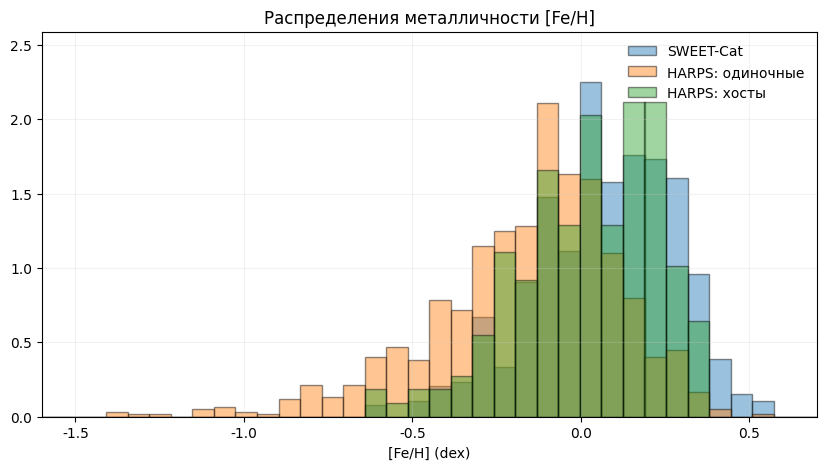

Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_feh_equalizer.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_feh_equalizer.gif exists: True


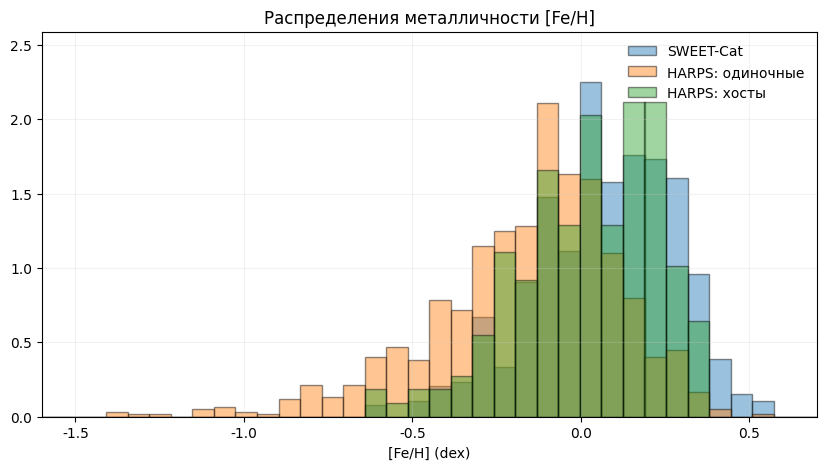

In [18]:
# =========================================================
# [ANIM_002] Metallicity distribution reveal ([Fe/H])
#   SWEET-Cat vs HARPS-GTO (single / hosts)
#   New architecture: processed CSVs only, i18n-safe
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load processed data
# -----------------------------
sweet = pd.read_csv(PROC / "sweetcat_ages_grid.csv")
harps = pd.read_csv(PROC / "harps_ages_grid.csv")

sweet_feh = sweet["feh"].dropna()
harps_single_feh = harps.loc[harps["class"] == "single", "feh"].dropna()
harps_host_feh   = harps.loc[harps["class"] != "single", "feh"].dropna()

print("SWEET [Fe/H]:", len(sweet_feh))
print("HARPS single [Fe/H]:", len(harps_single_feh))
print("HARPS host [Fe/H]:", len(harps_host_feh))

# -----------------------------
# 2) i18n text (L/T only)
# -----------------------------
X_FEH  = L("feh")
Y_NORM = L("density")  
TITLE = T("figure_2")

LEG_SWEET = L("legend_sweet")
LEG_HSING = L("legend_harps_single")
LEG_HHOST = L("legend_harps_host")

# -----------------------------
# 3) Common histogram settings
# -----------------------------
rmin, rmax = -1.6, 0.7     # paper-like stable range
bins = 36
frames = 80

series = [sweet_feh, harps_single_feh, harps_host_feh]
labels = [LEG_SWEET, LEG_HSING, LEG_HHOST]

# -----------------------------
# 4a) Strict linear reveal
# -----------------------------
anim_strict = animate_hist_reveal(
    series,
    labels=labels,
    colors=None,                 # let matplotlib/theme decide
    title=TITLE,
    xlabel=X_FEH,
    bins=bins,
    rmin=rmin,
    rmax=rmax,
    frames=frames,
    interval=1000 / FPS,
)

save_animation(anim_strict, anim_base("FeH_STRICT"))
plt.show()

# -----------------------------
# 4b) Equalizer-style reveal
# -----------------------------
anim_eq = animate_hist_equalizer(
    series,
    labels=labels,
    colors=None,
    title=TITLE,
    xlabel=X_FEH,
    bins=bins,
    rmin=rmin,
    rmax=rmax,
    frames=frames + 10,
    interval=1000 / FPS,
    jitter_strength=0.9,
    settle_last=10,
)

save_animation(anim_eq, anim_base("FeH_EQUALIZER"))
plt.show()

---

### 2.3. Birth radius distributions: Toy vs Minchev-like GCE (animations)

#### Purpose of these cells

These two cells visualize and compare **stellar birth-radius distributions** reconstructed using two different Galactic chemical evolution prescriptions:

- a **toy GCE model**, and  
- a more **Minchev-like (realistic) GCE model**.

Both animations are based on the **SWEET-Cat** stellar sample and use **precomputed, processed CSV files only**, ensuring full reproducibility and independence from external services.

The goal is to highlight how different assumptions about Galactic chemical evolution affect the inferred **radial origin of stars**, while keeping the underlying stellar sample fixed.


#### Input data

The animations load two processed datasets produced earlier in the pipeline:

- `sweetcat_rbirth_toy.csv`  
  Contains reconstructed stellar birth radii using the **toy GCE model**.

- `sweetcat_rbirth_gce.csv`  
  Contains reconstructed stellar birth radii using the **Minchev-like GCE model**.

In both files, the relevant quantity is stored in the column:

- `rbirth_kpc` — Galactocentric birth radius in kiloparsecs.

Only finite values are retained for visualization.


#### Common visualization setup

For both animations:

- The x-axis shows **Galactocentric birth radius** $r_{\rm birth}$ (kpc).
- The y-axis shows **normalized density**, allowing direct comparison of distribution shapes.
- A fixed radial range (0–15 kpc) and identical binning are used to ensure consistency.
- Labels and titles are retrieved via the **i18n system**, making the animation language-independent.
- Output format (MP4 or GIF), frame rate, and resolution are controlled by the global animation bootstrap settings.


#### Linear reveal animation

**Concept**

The linear reveal animation gradually increases the height of each histogram bin from zero to its final value.

- All bins grow **monotonically and synchronously**.
- No artificial motion or jitter is introduced.
- The final frames show the exact, static histogram.

**Why this is useful**

- Provides a clean, publication-style view of the final distributions.
- Makes it easy to compare the overall shape, peak position, and radial extent of the toy and Minchev-like reconstructions.
- Serves as a stable reference animation suitable for explanatory or didactic contexts.


#### Equalizer-style reveal animation

**Concept**

The equalizer-style animation adds **temporarily smoothed stochastic motion** to the histogram bars:

- Bars rise toward their final heights but exhibit correlated, neighbor-coherent fluctuations.
- The amplitude of this “jitter” decays smoothly over time.
- The final frames settle into the exact, noise-free histogram.

**Why this is useful**

- Enhances visual engagement in short explanatory videos.
- Emphasizes that the distributions are statistical in nature, not rigid deterministic curves.
- Naturally draws attention to differences between the two GCE models during the reveal phase.

#### Scientific interpretation

Together, these animations illustrate that:

- The **toy GCE model** and the **Minchev-like model** produce systematically different birth-radius distributions, even for the same stellar sample.
- Differences in gradient evolution and enrichment history translate directly into shifts and reshaping of inferred $r_{\rm birth}$ distributions.
- Visual comparison helps build intuition for how sensitive reconstructed Galactic histories are to the assumed chemical evolution prescription.

These animations therefore provide an effective bridge between **abstract GCE modeling assumptions** and their **observable consequences** in reconstructed stellar populations.

#### 2.3.1. Toy vs GCE - Linear

Toy rbirth: 425 | Minchev-like rbirth: 605
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_rbirth_toy_vs_minchev_linear.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_rbirth_toy_vs_minchev_linear.gif exists: True


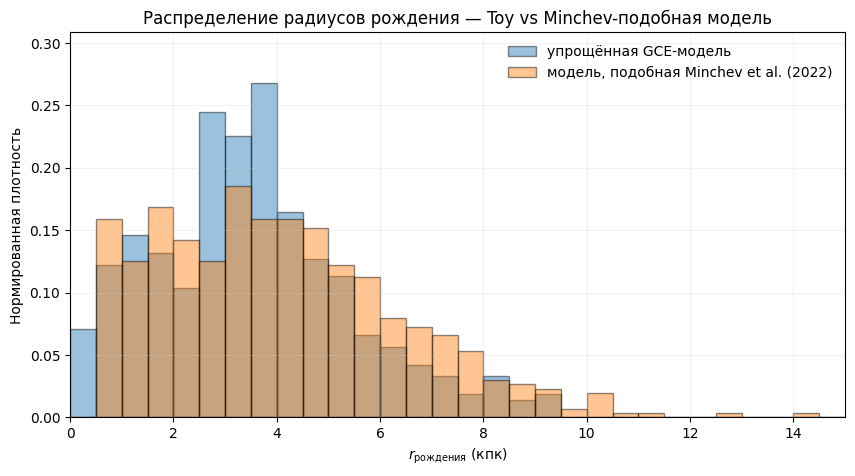

In [19]:
# =========================================================
# [ANIM_003b] Birth radius distribution: Toy vs Minchev-like (linear reveal)
#   SWEET-Cat (toy model CSV vs GCE/minchev-like CSV)
#   New architecture: processed CSVs only, i18n-safe
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load processed data
# -----------------------------
toy_path = PROC / "sweetcat_rbirth_toy.csv"
gce_path = PROC / "sweetcat_rbirth_gce.csv"

df_toy = pd.read_csv(toy_path)
df_gce = pd.read_csv(gce_path)

need = {"rbirth_kpc"}
miss_toy = need - set(df_toy.columns)
miss_gce = need - set(df_gce.columns)
if miss_toy:
    raise KeyError(f"Missing columns in {toy_path.name}: {sorted(miss_toy)}")
if miss_gce:
    raise KeyError(f"Missing columns in {gce_path.name}: {sorted(miss_gce)}")

rbirth_toy = df_toy["rbirth_kpc"].dropna().astype(float)
rbirth_min = df_gce["rbirth_kpc"].dropna().astype(float)

print("Toy rbirth:", len(rbirth_toy), "| Minchev-like rbirth:", len(rbirth_min))

# -----------------------------
# 2) i18n text
# -----------------------------
X_RB   = L("r_birth")
Y_NORM = L("density")

TITLE  = T("figure_3")

LEG_TOY = L("legend_toy")
LEG_MIN = L("legend_minchev")


# -----------------------------
# 3) Common histogram settings
# -----------------------------
bins = 30
rmin, rmax = 0.0, 15.0
frames = 60

# -----------------------------
# 4) Build + save animation (linear reveal)
#   NOTE: animate_hist_reveal() must accept ylabel= (like you fixed for equalizer)
# -----------------------------
anim = animate_hist_reveal(
    [rbirth_toy, rbirth_min],
    labels=[LEG_TOY, LEG_MIN],
    colors=None,                 # let theme/mpl decide
    title=TITLE,
    xlabel=X_RB,
    ylabel=Y_NORM,               # <- IMPORTANT: no global LABELS dict anymore
    bins=bins,
    rmin=rmin,
    rmax=rmax,
    frames=frames,
    interval=1000 / FPS,
)

save_animation(anim, anim_base("rbirth_Toy_vs_Minchev_LINEAR"))
plt.show()

#### 2.3.2. Toy vs GCE - Equalizer

Toy rbirth: 425 | Minchev-like rbirth: 605
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_rbirth_toy_vs_minchev_eq.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_rbirth_toy_vs_minchev_eq.gif exists: True


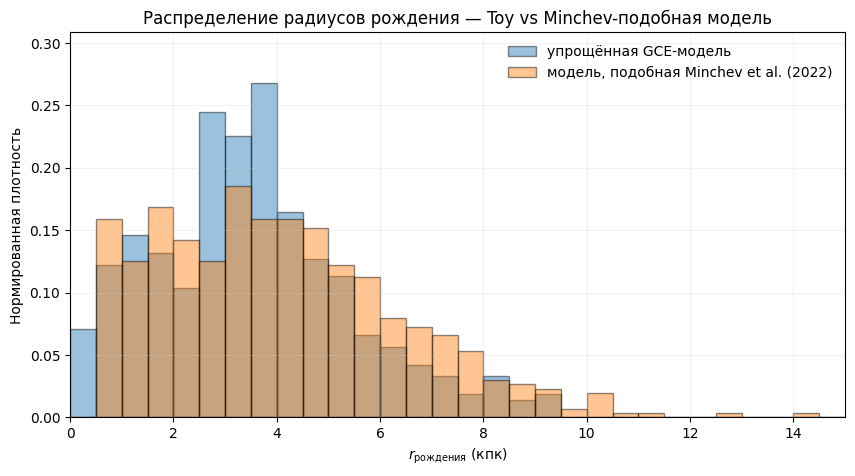

In [20]:
# =========================================================
# [ANIM_003] Birth radius distribution: Toy vs Minchev-like
#   SWEET-Cat (toy model CSV vs GCE/minchev-like CSV)
#   New architecture: processed CSVs only, i18n-safe
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load processed data
# -----------------------------
toy_path = PROC / "sweetcat_rbirth_toy.csv"
gce_path = PROC / "sweetcat_rbirth_gce.csv"

df_toy = pd.read_csv(toy_path)
df_gce = pd.read_csv(gce_path)

# both files store the reconstructed birth radius as rbirth_kpc
need = {"rbirth_kpc"}
miss_toy = need - set(df_toy.columns)
miss_gce = need - set(df_gce.columns)
if miss_toy:
    raise KeyError(f"Missing columns in {toy_path.name}: {sorted(miss_toy)}")
if miss_gce:
    raise KeyError(f"Missing columns in {gce_path.name}: {sorted(miss_gce)}")

rbirth_toy = df_toy["rbirth_kpc"].dropna().astype(float)
rbirth_minchev = df_gce["rbirth_kpc"].dropna().astype(float)

print("Toy rbirth:", len(rbirth_toy), "| Minchev-like rbirth:", len(rbirth_minchev))

# -----------------------------
# 2) i18n text
# -----------------------------
X_RB   = L("r_birth")
Y_NORM = L("density")

TITLE  = T("figure_3")

LEG_TOY = L("legend_toy")
LEG_MIN = L("legend_minchev")

# -----------------------------
# 3) Animation settings
# -----------------------------
bins = 30
rmin, rmax = 0.0, 15.0
frames = 80

# -----------------------------
# 4) Build + save animation (equalizer style)
# -----------------------------
anim = animate_hist_equalizer(
    [rbirth_toy, rbirth_minchev],
    labels=[LEG_TOY, LEG_MIN],
    colors=None,               # let theme/mpl decide
    title=TITLE,
    xlabel=X_RB,
    ylabel=Y_NORM,             # <- IMPORTANT: no global LABELS dict anymore
    bins=bins,
    rmin=rmin,
    rmax=rmax,
    frames=frames,
    interval=1000 / FPS,
    jitter_strength=0.9,
    settle_last=10,
    smooth_kernel=(1, 3, 5, 3, 1),
    smooth_passes=2,
)

save_animation(anim, anim_base("rbirth_Toy_vs_Minchev_EQ"))
plt.show()

### 2.4. Age and birth radius dependence (2×2 layout)

This final animation condenses the main results of the notebook into a single,
compact **2×2 animated figure**.

#### Layout
- **Rows**:
  - Top: **SWEET-Cat**
  - Bottom: **HARPS-GTO**
- **Columns**:
  - Left: **stellar age**
  - Right: **stellar birth radius** ($r_{\rm birth}$)

Each quadrant consists of **two vertically stacked panels**:
1. **Upper panel** — absolute star counts per bin:
   - single stars
   - high-mass planet hosts (HMPHs)
   - low-mass planet hosts (LMPHs)
2. **Lower panel** — planet-host formation efficiency:
   - fraction of HMPHs and LMPHs relative to all stars
   - Wilson 68% confidence intervals are shown once the animation settles

#### Animation logic
The animation proceeds in clearly separated phases:
1. **Counts reveal (0–60%)**  
   Binned star counts appear progressively from left to right.
2. **Frequency reveal (60–85%)**  
   Planet-host fractions appear without error bars.
3. **Final settle (85–100%)**  
   Wilson confidence intervals are added.
4. **Hold frame**  
   The final state is held for several seconds to allow visual inspection.

#### Technical notes
- Uses **processed CSV tables only** (no Vizier / NEA queries).
- Works with the unified `class` column:
  - `single`, `HMPH`, `LMPH`
- Fully **i18n-safe**: all labels, titles, and legends are resolved via YAML.
- A single animation file is produced, ensuring consistency across platforms
  and simplifying downstream video editing.

This summary animation replaces multiple separate figures and provides a
high-level, publication-ready overview of the trends explored throughout the notebook.

SWEET: 605 
 HMPH      436
LMPH      101
single     68
Name: class, dtype: int64
HARPS: 466 
 single    385
HMPH       66
LMPH       15
Name: class, dtype: int64
Target: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_summary_2x2.gif
Saved: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations/ANIM_001_summary_2x2.gif exists: True


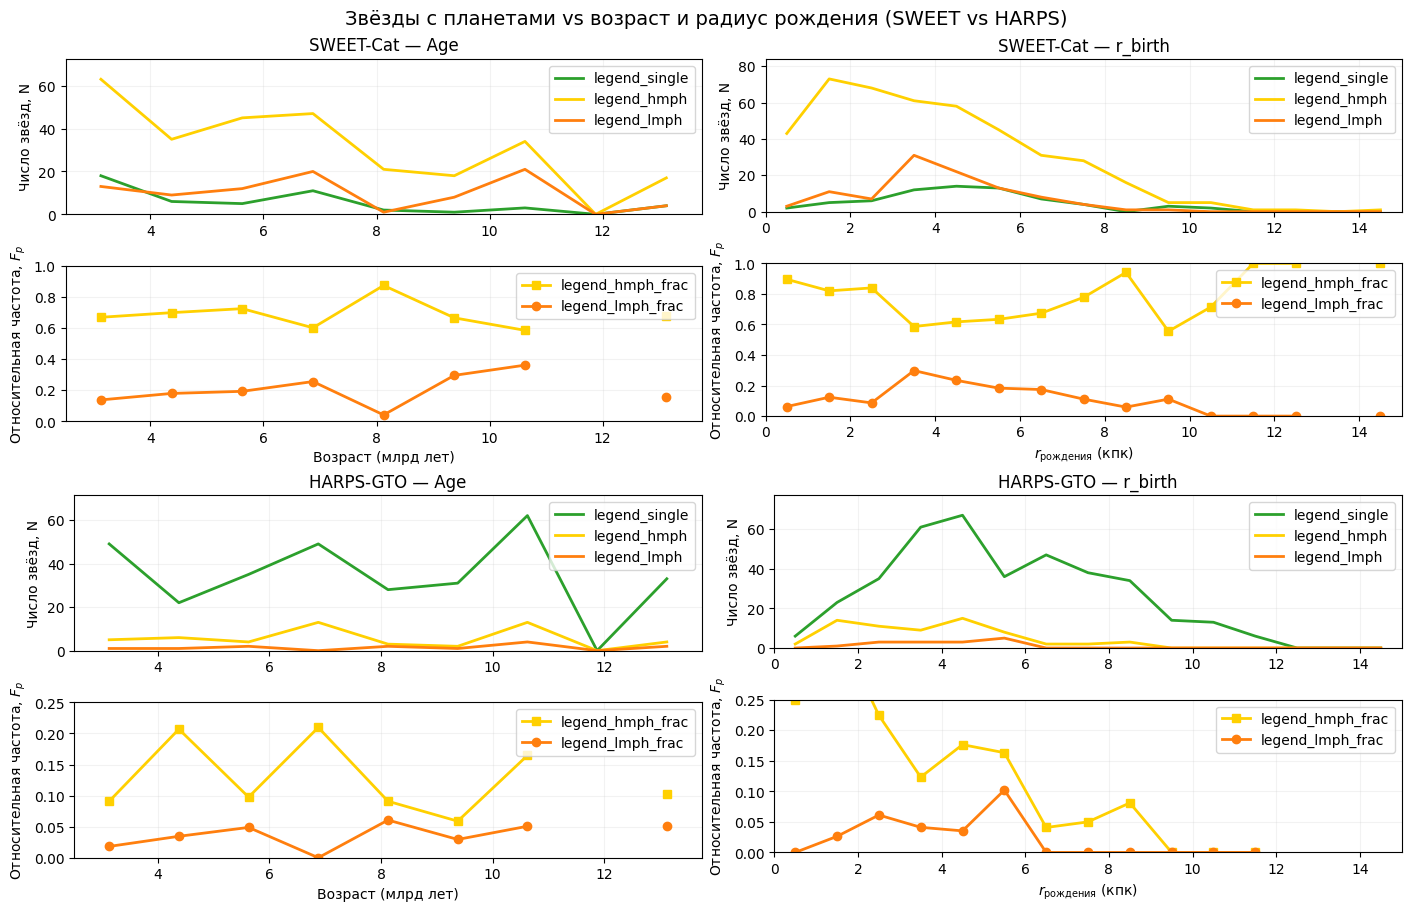

In [21]:
# =========================================================
# [ANIM_001|ANIM_003] ONE 2x2 summary animation
#   Rows: SWEET / HARPS
#   Cols: Age / r_birth
#   Each block has 2 panels: counts (top) + frequency (bottom)
#   New architecture: processed CSVs only, i18n-safe
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -----------------------------
# 1) Load processed data
# -----------------------------
sweet = pd.read_csv(PROC / "sweetcat_rbirth_gce.csv")
harps = pd.read_csv(PROC / "harps_rbirth_gce.csv")

need = {"age_gyr", "class"}
miss_s = need - set(sweet.columns)
miss_h = need - set(harps.columns)
if miss_s:
    raise KeyError(f"SWEET processed table missing columns: {sorted(miss_s)}")
if miss_h:
    raise KeyError(f"HARPS processed table missing columns: {sorted(miss_h)}")

if "rbirth_kpc" not in sweet.columns or "rbirth_kpc" not in harps.columns:
    raise KeyError("Expected 'rbirth_kpc' in both sweetcat_rbirth_gce.csv and harps_rbirth_gce.csv")

sweet = sweet.rename(columns={"rbirth_kpc": "rbirth_plot"})
harps = harps.rename(columns={"rbirth_kpc": "rbirth_plot"})

def _clean(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out = out.dropna(subset=["age_gyr", "rbirth_plot", "class"])
    out = out[np.isfinite(out["age_gyr"].to_numpy())]
    out = out[np.isfinite(out["rbirth_plot"].to_numpy())]
    out = out[(out["age_gyr"] >= 0.1) & (out["age_gyr"] <= 13.5)]
    out = out[(out["rbirth_plot"] >= 0.0) & (out["rbirth_plot"] <= 20.0)]
    return out

sweet = _clean(sweet)
harps = _clean(harps)

print("SWEET:", len(sweet), "\n", sweet["class"].value_counts())
print("HARPS:", len(harps), "\n", harps["class"].value_counts())

# -----------------------------
# 2) i18n text
# -----------------------------
X_AGE  = L("age_gyr")
X_RB   = L("r_birth")
Y_CNT  = L("n_stars")
Y_FREQ = L("rel_freq")

LEG_SINGLE = L("legend_single")
LEG_HMPH   = L("legend_hmph")
LEG_LMPH   = L("legend_lmph")
LEG_HMPH_F = L("legend_hmph_frac")
LEG_LMPH_F = L("legend_lmph_frac")

TITLE_MAIN  = T("figure_4")
TITLE_SWEET = T("figure_4_sweet")
TITLE_HARPS = T("figure_4_harps")


# -----------------------------
# 3) Binning
# -----------------------------
age_bins = np.arange(2.5, 13.5 + 1.25, 1.25)
age_cent = 0.5 * (age_bins[:-1] + age_bins[1:])

r_bins = np.arange(0.0, 15.0 + 1.0, 1.0)
r_cent = 0.5 * (r_bins[:-1] + r_bins[1:])

# -----------------------------
# 4) Stats helpers (Wilson 68%)
# -----------------------------
def wilson_interval(k, n, z=1.0):
    k = np.asarray(k, dtype=float)
    n = np.asarray(n, dtype=float)
    p = np.divide(k, n, out=np.full_like(k, np.nan), where=(n > 0))

    nn = np.where(n > 0, n, 1.0)
    denom  = 1.0 + (z**2) / nn
    center = (p + (z**2)/(2*nn)) / denom
    half   = (z * np.sqrt((p*(1-p) + (z**2)/(4*nn)) / nn)) / denom

    lo = center - half
    hi = center + half
    return p, lo, hi

def counts_in_bins(df, xcol, bins, cls):
    x = df.loc[df["class"] == cls, xcol].to_numpy(dtype=float)
    return np.histogram(x, bins=bins)[0]

# -----------------------------
# 5) Build full time-series for each block
# -----------------------------
def compute_block(df, xcol, bins):
    Ns = counts_in_bins(df, xcol, bins, "single")
    Nh = counts_in_bins(df, xcol, bins, "HMPH")
    Nl = counts_in_bins(df, xcol, bins, "LMPH")
    Nt = Ns + Nh + Nl

    ph, loh, hih = wilson_interval(Nh, Nt, z=1.0)
    pl, lol, hil = wilson_interval(Nl, Nt, z=1.0)

    yerr_h = np.vstack([ph - loh, hih - ph])
    yerr_l = np.vstack([pl - lol, hil - pl])

    return {
        "Ns": Ns, "Nh": Nh, "Nl": Nl, "Nt": Nt,
        "ph": ph, "pl": pl,
        "yerr_h": yerr_h, "yerr_l": yerr_l,
    }

blk_sa = compute_block(sweet, "age_gyr", age_bins)
blk_sr = compute_block(sweet, "rbirth_plot", r_bins)
blk_ha = compute_block(harps, "age_gyr", age_bins)
blk_hr = compute_block(harps, "rbirth_plot", r_bins)

# -----------------------------
# 6) Plot scaffolding (8 axes total)
# -----------------------------
# Colors: simple defaults, readable on both themes
c_single = "tab:green"
c_hmph   = "#FFD000"
c_lmph   = "tab:orange"
lw = 2.0
ms = 6

fig = plt.figure(figsize=(14, 9), constrained_layout=True)
outer = fig.add_gridspec(2, 2)

def make_block(gs, title_row, title_col, xlabel, xlim, freq_ylim):
    """
    Returns (ax_counts, ax_freq, artists_dict)
    """
    sub = gs.subgridspec(2, 1, height_ratios=[1.0, 1.0], hspace=0.05)
    axc = fig.add_subplot(sub[0, 0])
    axf = fig.add_subplot(sub[1, 0], sharex=axc)

    axc.set_title(f"{title_row} — {title_col}")
    axc.set_ylabel(Y_CNT)
    axc.grid(True, alpha=0.25)
    axc.set_xlim(*xlim)

    axf.set_xlabel(xlabel)
    axf.set_ylabel(Y_FREQ)
    axf.grid(True, alpha=0.25)
    axf.set_xlim(*xlim)
    axf.set_ylim(*freq_ylim)

    # counts lines
    lNs, = axc.plot([], [], lw=lw, color=c_single, label=LEG_SINGLE)
    lNh, = axc.plot([], [], lw=lw, color=c_hmph,   label=LEG_HMPH)
    lNl, = axc.plot([], [], lw=lw, color=c_lmph,   label=LEG_LMPH)
    axc.legend(loc="upper right", frameon=True)

    # frequency errorbar "containers" (we will update their Line2D + segments)
    eH = axf.errorbar([], [], yerr=None, fmt="s-", ms=ms, lw=lw, capsize=3, color=c_hmph, label=LEG_HMPH_F)
    eL = axf.errorbar([], [], yerr=None, fmt="o-", ms=ms, lw=lw, capsize=3, color=c_lmph, label=LEG_LMPH_F)
    axf.legend(loc="upper right", frameon=True)

    return axc, axf, {"lNs": lNs, "lNh": lNh, "lNl": lNl, "eH": eH, "eL": eL}

def _clear_errorbar(errc):
    # errc.lines: [line, caplines, barlinecols]
    errc.lines[0].set_data([], [])
    for c in errc.lines[1]:
        c.set_data([], [])
    for bc in errc.lines[2]:
        bc.set_segments([])

def _set_errorbar(errc, x, y, yerr):
    errc.lines[0].set_data(x, y)
    # caps are optional; barlinecols is where segments live
    for c in errc.lines[1]:
        c.set_data([], [])
    for bc in errc.lines[2]:
        bc.set_segments([])

    if yerr is None or len(x) == 0:
        return

    if len(errc.lines[2]) == 0:
        return

    segs = []
    for xi, yi, lo, hi in zip(x, y, yerr[0], yerr[1]):
        segs.append([[xi, yi - lo], [xi, yi + hi]])
    errc.lines[2][0].set_segments(segs)

# Create 4 blocks
ax_sa_c, ax_sa_f, A_sa = make_block(outer[0, 0], TITLE_SWEET, "Age",     X_AGE, (age_bins[0], age_bins[-1]), (0, 1.0))
ax_sr_c, ax_sr_f, A_sr = make_block(outer[0, 1], TITLE_SWEET, "r_birth", X_RB,  (r_bins[0],  r_bins[-1]),    (0, 1.0))
ax_ha_c, ax_ha_f, A_ha = make_block(outer[1, 0], TITLE_HARPS, "Age",     X_AGE, (age_bins[0], age_bins[-1]), (0, 0.25))
ax_hr_c, ax_hr_f, A_hr = make_block(outer[1, 1], TITLE_HARPS, "r_birth", X_RB,  (r_bins[0],  r_bins[-1]),    (0, 0.25))

fig.suptitle(TITLE_MAIN, fontsize=14)

# Set count y-limits per block (stable)
def set_count_ylim(axc, blk):
    ymax = max(int(blk["Ns"].max()), int(blk["Nh"].max()), int(blk["Nl"].max()), 1)
    axc.set_ylim(0, ymax * 1.15)

set_count_ylim(ax_sa_c, blk_sa)
set_count_ylim(ax_sr_c, blk_sr)
set_count_ylim(ax_ha_c, blk_ha)
set_count_ylim(ax_hr_c, blk_hr)

# -----------------------------
# 7) Animation schedule (3s motion + 3s hold)
# -----------------------------
anim_seconds = 3.0
hold_seconds = 3.0
frames_anim  = max(1, int(round(anim_seconds * FPS)))
frames_hold  = max(0, int(round(hold_seconds * FPS)))
frames_total = frames_anim + frames_hold

# Phase split inside motion:
# 0..60%: counts reveal
# 60..85%: freq points reveal (no errorbars)
# 85..100%: add errorbars
p_counts = 0.60
p_points = 0.85

def update(frame):
    # hold final frame
    if frame >= frames_anim:
        return []

    t = (frame + 1) / frames_anim

    def apply_block(blk, xcent, A):
        n = len(xcent)

        # counts reveal
        if t < p_counts:
            k = max(1, int(n * (t / p_counts)))
        else:
            k = n

        A["lNs"].set_data(xcent[:k], blk["Ns"][:k])
        A["lNh"].set_data(xcent[:k], blk["Nh"][:k])
        A["lNl"].set_data(xcent[:k], blk["Nl"][:k])

        # frequency reveal
        if t < p_counts:
            _clear_errorbar(A["eH"])
            _clear_errorbar(A["eL"])
            return

        if t < p_points:
            kk = max(1, int(n * ((t - p_counts) / (p_points - p_counts))))
            _set_errorbar(A["eH"], xcent[:kk], blk["ph"][:kk], None)
            _set_errorbar(A["eL"], xcent[:kk], blk["pl"][:kk], None)
        else:
            kk = n
            _set_errorbar(A["eH"], xcent[:kk], blk["ph"][:kk], blk["yerr_h"][:, :kk])
            _set_errorbar(A["eL"], xcent[:kk], blk["pl"][:kk], blk["yerr_l"][:, :kk])

    apply_block(blk_sa, age_cent, A_sa)
    apply_block(blk_sr, r_cent,   A_sr)
    apply_block(blk_ha, age_cent, A_ha)
    apply_block(blk_hr, r_cent,   A_hr)

    return []

anim = FuncAnimation(fig, update, frames=frames_total, interval=int(1000 / FPS), blit=False)

# Force a draw on the final motion frame (avoids occasional blank saves)
update(frames_anim - 1)
fig.canvas.draw()

save_animation(anim, anim_base("summary_2x2"))
plt.show()

## Notebook conclusion

This notebook completes the transition from static diagnostic plots to a
fully reproducible **animation-first workflow** for stellar and exoplanet
population analysis.

### Key outcomes
- All animations are generated from **processed, version-controlled CSV data**.
- Plotting logic is cleanly separated from:
  - data preparation,
  - internationalization (i18n),
  - animation export.
- Multiple visualization styles (histogram reveal, equalizer, scatter reveal)
  are implemented as **reusable helpers** rather than notebook-specific code.

### Scientific perspective
The final 2×2 summary animation highlights consistent trends across
independent samples (SWEET-Cat and HARPS-GTO):
- the evolution of planet-host fractions with stellar age,
- the dependence of planet occurrence on stellar birth radius,
- the contrast between high-mass and low-mass planet hosts.

By presenting counts and efficiencies together, the animations make
selection effects and statistical uncertainties visually explicit.

### Practical perspective
This notebook is now suitable for:
- direct export to **MP4/GIF** for talks and outreach,
- inclusion in **supplementary material**,
- reuse as a template for future datasets or extended samples.

In short, the notebook now functions not only as an analysis tool,
but as a **production-ready visualization module** within the broader project.

In [22]:
print("ANIM_FORMAT =", ANIM_FORMAT)

ANIM_FORMAT = gif
